This notebook is a simple example of how to run the bcktst package. It uses the strategy derived in part 1

# Imports

In [1]:
from bcktst.bundle import Bundle
from bcktst.trader import Trader
from bcktst.broker import Broker
from bcktst import eval_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
sns.set()

# Data imports

In [2]:
start_date = '2016-01-04'

# The trading signal was calculated in part 1 of this notebook.
trading_signal = pd.read_csv('data/trading_signal.csv', index_col=0, converters={0:pd.to_datetime}, squeeze=True)
trading_signal = trading_signal.resample('D').ffill()

# We use roll adjusted WTI 1m prices from Quandl
prices = pd.read_csv('data/wti_ra.csv', index_col=0, converters={0: pd.to_datetime})[start_date:]  
calendar_spread =  prices['WTI_1m_ra']

In [3]:
# We create a bundle, which just concatenate the input pandas objects after resampling them
bundle = Bundle([calendar_spread.rename('close'), trading_signal.rename('all_farms_ewa')])
bundle.data.head()

close  all_farms_ewa
2016-03-02  31.43            1.0
2016-03-03  31.34            1.0
2016-03-04  32.69            1.0
2016-03-05  32.69            1.0
2016-03-06  32.69            1.0

# BCKTST

Instantiation of some bcktst classes

In [4]:
# We create a broker, in charge of passing and recording trades
broker = Broker()

# We create a trader, who reads the bundle and sends trades to teh broker
trader = Trader(broker, bundle, new_trade_col_name='all_farms_ewa', horizon=timedelta(weeks=1))

# The trader runs the strategy line by line (<=> day by day )
results = trader.run()
results.to_csv('data/results.csv')
results.tail()

close  all_farms_ewa  portfolio_value      cash  mkt_position  \
2018-09-15  55.16           -1.0         15579.79  30417.83        -269.0   
2018-09-16  55.16           -1.0         15579.79  30417.83        -269.0   
2018-09-17  55.08           -1.0         15601.31  30417.83        -269.0   
2018-09-18  55.99           -1.0         15356.52  30417.83        -269.0   
2018-09-19  57.17           -1.0         15039.10  30131.98        -264.0   

            order_size order_type  
2018-09-15         NaN        NaN  
2018-09-16         NaN        NaN  
2018-09-17         NaN        NaN  
2018-09-18         NaN        NaN  
2018-09-19         5.0        buy

As we can see, all variables are logged into results: not only prices but trades, portfolio values...

# Results

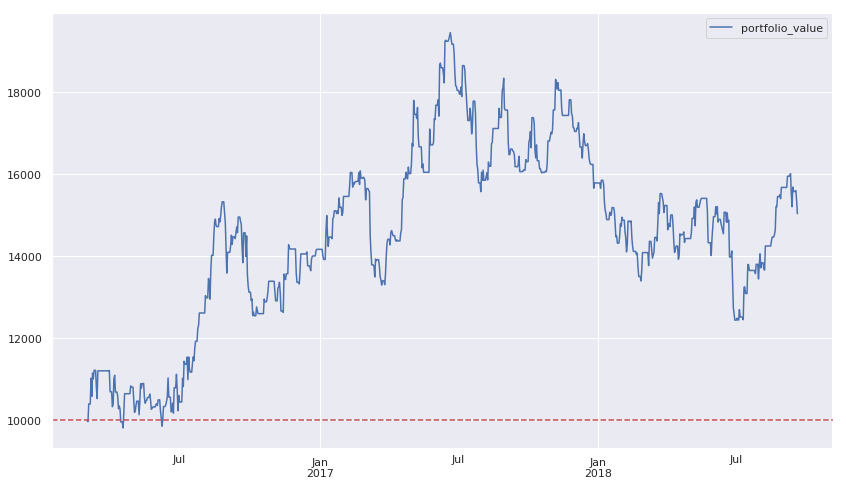

In [5]:
results.plot(y='portfolio_value', figsize=(14,8))
plt.axhline(y=10000, color='r', ls='--');

In [6]:
returns = results.portfolio_value.pct_change()
returns.plot(title='Daily return in %', figsize=(7,4));

The bcktst.eval_metrics provide useful classes for further analysis of our results.

In [7]:
r_analysis = eval_metrics.RatioAnalysis(returns)
print('Sharpe Ratio: {:.3f}'.format(r_analysis.sharpe_ratio()))
print('Sortino Ratio: {:.3f}'.format(r_analysis.sortino_ratio()))

Sharpe Ratio: 0.541
Sortino Ratio: 0.929
